## Load necessary libraries

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from time import time
import copy
import pandas as pd
from tqdm import tqdm

## Load, normalize, and visualize the MNIST dataset.

In [3]:
def load_MNIST():
    """Function to load and normalize MNIST data"""
    train = torchvision.datasets.MNIST(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ]))
    test = torchvision.datasets.MNIST(root='./data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ]))
    print("MNIST datset loaded and normalized.")
    train_loader = torch.utils.data.DataLoader(dataset=train, shuffle=True, batch_size=100)
    test_loader = torch.utils.data.DataLoader(dataset=test, shuffle=False, batch_size=100)
    print("PyTorch DataLoaders loaded.")
    return train, test, train_loader, test_loader

In [4]:
def visualize_MNIST(train_loader):
    """Function to visualize data given a DataLoader object"""
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    print("image shape:", images.shape, "\n label shape:", labels.shape)
    # visualize data
    fig, ax = plt.subplots(2,5)
    for i, ax in enumerate(ax.flatten()):
          im_idx = np.argwhere(labels == i)[0][0]
          plottable_image = images[im_idx].squeeze()
          ax.imshow(plottable_image)

9920512it [00:02, 4197703.46it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 69300.46it/s]            


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:01, 1402883.06it/s]                             


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 25486.04it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
MNIST datset loaded and normalized.
PyTorch DataLoaders loaded.
image shape: torch.Size([100, 1, 28, 28]) 
 label shape: torch.Size([100])


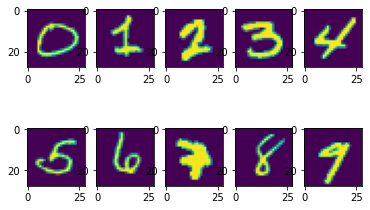

In [5]:
# load and visualize MNISt
train, test, train_loader, test_loader = load_MNIST()
visualize_MNIST(train_loader)

## Build a vanilla neural net with four hidden layers without pruning.


In [6]:
class Net(nn.Module):
    """A non-sparse neural network with four hidden fully-connected layers"""

    def __init__(self):
        super(Net,self).__init__()
        self.input_layer = nn.Linear(784, 1000, bias=False)
        self.hidden1_layer = nn.Linear(1000, 1000, bias=False)
        self.hidden2_layer = nn.Linear(1000, 500, bias=False)
        self.hidden3_layer = nn.Linear(500, 200, bias=False)
        self.hidden4_layer = nn.Linear(200, 10, bias=False)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        x = self.hidden1_layer(x)
        x = F.relu(x)
        x = self.hidden2_layer(x)
        x = F.relu(x)
        x = self.hidden3_layer(x)
        x = F.relu(x)
        x = self.hidden4_layer(x)
        output = F.log_softmax(x, dim=1)

        return output

## Train vanilla neural net.

In [8]:
def train(model, train_loader, epochs=3, learning_rate=0.001):
    """Function to train a neural net"""

    lossFunction = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    time0 = time()
    total_samples = 0

    for e in range(epochs):
        print("Starting epoch", e)
        total_loss = 0

    for idx, (images,labels) in enumerate(train_loader):
        images = images.view(images.shape[0],-1) # flatten
        optimizer.zero_grad() # forward pass
        output = model(images)
        loss = lossFunction(output,labels) # calculate loss
        loss.backward() # backpropagate
        optimizer.step() # update weights

        total_samples += labels.size(0)
        total_loss += loss.item()

        if idx % 100 == 0:
            print("Running loss:", total_loss)

    final_time = (time()-time0)/60
    print("Model trained in ", final_time, "minutes on ", total_samples, "samples")

In [9]:
model = Net()
train(model, train_loader)

Starting epoch 0
Starting epoch 1
Starting epoch 2
Running loss: 2.304272413253784
Running loss: 78.98088473081589
Running loss: 110.48359639942646
Running loss: 137.05089876800776
Running loss: 158.8832150399685
Running loss: 179.5798225849867
Model trained in  0.34126483599344887 minutes on  60000 samples


## Test our vanilla neural net.

In [11]:
def test(model, test_loader):
    """Test neural net"""

    correct = 0
    total = 0

    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            images = images.view(images.shape[0],-1) # flatten
            output = model(images)
            values, indices = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (labels == indices).sum().item()

        acc = correct / total * 100
        # print("Accuracy: ", acc, "% for ", total, "training samples")

    return acc

In [12]:
acc = test(model, test_loader)
print("The accuracy of our vanilla NN is", acc, "%")

The accuracy of our vanilla NN is 94.99 %


## A ~95% accuracy for our vanilla NN seems reasonable. Now let's do some weight and unit pruning.

In [13]:
def sparsify_by_weights(model, k):
    """Function that takes un-sparsified neural net and does weight-pruning
    by k sparsity"""

    # make copy of original neural net
    sparse_m = copy.deepcopy(model)

    with torch.no_grad():
        for idx, i in enumerate(sparse_m.parameters()):
            if idx == 4: # skip last layer of 5-layer neural net
                break
            # change tensor to numpy format, then set appropriate number of smallest weights to zero
            layer_copy = torch.flatten(i)
            layer_copy = layer_copy.detach().numpy()
            indices = abs(layer_copy).argsort() # get indices of smallest weights by absolute value
            indices = indices[:int(len(indices)*k)] # get k fraction of smallest indices
            layer_copy[indices] = 0

            # change weights of model
            i = torch.from_numpy(layer_copy)
            
    return sparse_m

In [14]:
def l2(array):
    return np.sqrt(np.sum([i**2 for i in array]))

def sparsify_by_unit(model, k):
    """Creates a k-sparsity model with unit-level pruning that sets columns with smallest L2 to zero."""

    # make copy of original neural net
    sparse_m = copy.deepcopy(model)

    for idx, i in enumerate(sparse_m.parameters()):
        if idx == 4: # skip last layer of 5-layer neural net
            break
        layer_copy = i.detach().numpy()
        indices = np.argsort([l2(i) for i in layer_copy])
        indices = indices[:int(len(indices)*k)]
        layer_copy[indices,:] = 0
        i = torch.from_numpy(layer_copy)

    return sparse_m


In [23]:
def get_pruning_accuracies(model, prune_type):
    """ Takes a model and prune type ("weight" or "unit") and returns a DataFrame of pruning accuracies for given sparsities."""

    df = pd.DataFrame({"sparsity": [], "accuracy": []})
    sparsities = [0.0, 0.25, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.97, 0.99]
    #sparsities = [0.0, 0.25, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99]
    #sparsities = [0.0]

    for s in tqdm(sparsities):
        if prune_type == "weight":
            print("Pruning with weight - sparsity %.2f"%s)
            new_model = sparsify_by_weights(model, s)
        elif prune_type == "unit":
            print("Pruning with unit - sparsity %.2f"%s)
            new_model = sparsify_by_unit(model, s)
        else:
            print("Must specify prune-type.")
            return
        acc = test(new_model, test_loader)
        df = df.append({"sparsity": s, "accuracy": acc}, ignore_index=True)

    return df

## Pruning results

In [24]:
df_weight = get_pruning_accuracies(model, "weight")
df_unit = get_pruning_accuracies(model, "unit")

print("Accuracies for Weight Pruning")
print(df_weight)

print()

print("Accuracies for Unit Pruning")
print(df_unit)

  0%|          | 0/10 [00:00<?, ?it/s]

Pruning with weight - sparsity 0.00


 10%|█         | 1/10 [00:01<00:14,  1.63s/it]

Pruning with weight - sparsity 0.25


 20%|██        | 2/10 [00:03<00:13,  1.68s/it]

Pruning with weight - sparsity 0.50


 30%|███       | 3/10 [00:05<00:11,  1.69s/it]

Pruning with weight - sparsity 0.60


 40%|████      | 4/10 [00:06<00:10,  1.71s/it]

Pruning with weight - sparsity 0.70


 50%|█████     | 5/10 [00:08<00:08,  1.73s/it]

Pruning with weight - sparsity 0.80


 60%|██████    | 6/10 [00:10<00:06,  1.74s/it]

Pruning with weight - sparsity 0.90


 70%|███████   | 7/10 [00:12<00:05,  1.75s/it]

Pruning with weight - sparsity 0.95


 80%|████████  | 8/10 [00:13<00:03,  1.78s/it]

Pruning with weight - sparsity 0.97


 90%|█████████ | 9/10 [00:15<00:01,  1.79s/it]

Pruning with weight - sparsity 0.99


  0%|          | 0/10 [00:00<?, ?it/s]

Pruning with unit - sparsity 0.00


 10%|█         | 1/10 [00:08<01:19,  8.87s/it]

Pruning with unit - sparsity 0.25


 20%|██        | 2/10 [00:17<01:11,  8.92s/it]

Pruning with unit - sparsity 0.50


 30%|███       | 3/10 [00:26<01:02,  8.98s/it]

Pruning with unit - sparsity 0.60


 40%|████      | 4/10 [00:35<00:54,  9.00s/it]

Pruning with unit - sparsity 0.70


 50%|█████     | 5/10 [00:44<00:44,  8.99s/it]

Pruning with unit - sparsity 0.80


 60%|██████    | 6/10 [00:53<00:35,  9.00s/it]

Pruning with unit - sparsity 0.90


 70%|███████   | 7/10 [01:02<00:27,  9.01s/it]

Pruning with unit - sparsity 0.95


 80%|████████  | 8/10 [01:11<00:17,  8.99s/it]

Pruning with unit - sparsity 0.97


 90%|█████████ | 9/10 [01:20<00:09,  9.00s/it]

Pruning with unit - sparsity 0.99


100%|██████████| 10/10 [01:29<00:00,  8.99s/it]

Accuracies for Weight Pruning
   sparsity  accuracy
0      0.00     94.99
1      0.25     94.98
2      0.50     94.89
3      0.60     94.94
4      0.70     94.35
5      0.80     94.15
6      0.90     88.44
7      0.95     80.77
8      0.97     73.42
9      0.99     46.40

Accuracies for Unit Pruning
   sparsity  accuracy
0      0.00     94.99
1      0.25     94.92
2      0.50     94.78
3      0.60     93.50
4      0.70     87.66
5      0.80     74.15
6      0.90     22.05
7      0.95     14.19
8      0.97     21.72
9      0.99     13.06


In [16]:
df_weight = get_pruning_accuracies(model, "weight")
df_unit = get_pruning_accuracies(model, "unit")

print("Accuracies for Weight Pruning")
print(df_weight)

print()

print("Accuracies for Unit Pruning")
print(df_unit)

Accuracies for Weight Pruning
   sparsity  accuracy
0      0.00     94.99
1      0.25     94.98
2      0.50     94.89
3      0.60     94.94
4      0.70     94.35
5      0.80     94.15
6      0.90     88.44
7      0.95     80.77
8      0.97     73.42
9      0.99     46.40

Accuracies for Unit Pruning
   sparsity  accuracy
0      0.00     94.99
1      0.25     94.92
2      0.50     94.78
3      0.60     93.50
4      0.70     87.66
5      0.80     74.15
6      0.90     22.05
7      0.95     14.19
8      0.97     21.72
9      0.99     13.06


## Visualize Results

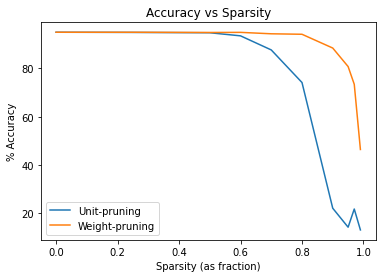

In [25]:
plt.figure()
plt.title("Accuracy vs Sparsity")
plt.plot(df_unit["sparsity"], df_unit["accuracy"], label="Unit-pruning")
plt.plot(df_weight["sparsity"], df_weight["accuracy"], label="Weight-pruning")
plt.xlabel("Sparsity (as fraction)")
plt.ylabel("% Accuracy")
plt.legend()